# Assignment 1
## Problem 1 - System Identification


This problem deals with different universal approximators for memoryless systems. For this purpose, a training set $X_{train}$ consisting of $N_{train}=50$, and a test set consisting of $N_{test}=30$ samples was given. Both sets represent i.i.d. samples of a static nonlinearity $f(\cdot)$, corrupted by additive measurement noise $\nu$, with $\nu_i \sim \mathcal{N}(0, \sigma_\nu^2)$.

![System identification setup](../../data/figures/system-identification_small.png)
&ensp;
&ensp;
&ensp;

<center>Setup for the system identification task of Problem 1</center>


In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# from src.models.mls_models import MyFancyModel
# from rbf_mlp import RbfNetwork
from src.utils.plotting import init_plot_style
%pylab
%matplotlib inline  

init_plot_style()
data_dir='../../data/csv/1_1_system_identification/'

warnings.filterwarnings('ignore') # Supress warnings from polyfit

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


First, let's take a look at the training and test data.

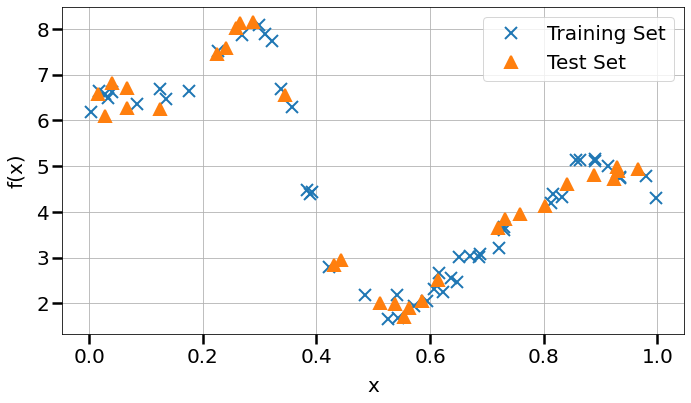

In [2]:
training_set = pd.read_csv(data_dir + 'training-set.csv').to_numpy()
x_train, y_train = training_set[:,0], training_set[:,1]

test_set = pd.read_csv(data_dir + 'test-set.csv').to_numpy()
x_test, y_test = test_set[:,0], test_set[:,1]

plt.close('all')
plt.figure(figsize=(10,6))
plt.plot(x_train, y_train, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Run your experiments from here on!

<hr style='border:2.2px solid Black'></hr>

**Defenition of some functions for Task 1**

In [3]:
#Compute the MSE of the given coefficents p

def MSE(p,x,y):
        """Computing the 1D-MSE, given the polynomial coefficents p, the places x and the data y  """
        y_hat = np.polyval(p,x) 
        error = (y_hat-y)**2    
        mse = np.mean(error)
        return mse
    
    
# Evaluate the polynomial model
    
def PolyModelEval(order, x_fit, y_fit, x):
        """Evaluate the poly model, fited to the data [x_fit, y_fit] at x"""
        p = np.polyfit(x_fit, y_fit, order, full=False)
        y_hat = np.polyval(p,x)
        return y_hat
    
# For RBF linear least squares solution

def RbfOptimizer(P, w, x):
        """Compute the matrix A for finding the linear least squares solution based on the data x."""
        rbf_center = np.arange(0,1,1/P)
        A = np.ones([np.size(x), P])
        
        for i in range(0,np.size(x)):
            for j in range(1,P):
                A[i,j] = np.exp(1)**(-(x[i]-rbf_center[j])**2/w)
        return A
    

<hr style='border:2.2px solid Black'></hr>

**Task a)**

The training set should be used to find a polynomial model:
\begin{equation}
    \hat{f}(x) = \sum_{p=0}^P \alpha_px^p
\end{equation}
of order P ($P_{max}=25$), and with the parameters $\theta = \{\alpha_p\}_{p=1}^P$ which is optimal with respect to the mean squared error (MSE):
\begin{equation}
    J(\theta, P) = \frac{1}{N}\sum_{i=0}^{N-1}e_i^2
\end{equation}

In [4]:
#First test with polyfit

P_max = 25
residuals_train = np.zeros(P_max-1)
residuals_test = np.zeros(P_max-1)

for order in range(1,P_max):
    
    p = np.polyfit(x_train, y_train, order, full=False)
    residuals_train[order-1] = MSE(p,x_train, y_train)
    residuals_test[order-1] = MSE(p,x_test, y_test)
    
train_min = np.where(residuals_train == np.amin(residuals_train)) #optimal order
test_min = np.where(residuals_test == np.amin(residuals_test))    #optimal order


Visual inspection of the results:

In [5]:
#Plot of MSE for train and test 

#Plotting uncommented as the figures are included in the markdown cells!


#plt.figure(figsize=(10,6))
#plt.plot(np.arange(1,P_max),residuals_train, label='Training Set')
#plt.plot(np.arange(1,P_max), residuals_test, label='Test Set')
#plt.legend()
#plt.xlabel('Polynomial order P')
#plt.ylabel('MSE')
#plt.grid()
#plt.tight_layout()
#plt.show()


print('Optimal polynomial order for training set: ', train_min[0]+1, 'with MSE: ', residuals_train[train_min[0]])
print('Optimal polynomial order for test set: ', test_min[0]+1, 'with MSE: ', residuals_test[test_min[0]])

#Plot the optimal model with training/test set

x_eval = np.arange(0,1,0.005)
opt_train_model = PolyModelEval(train_min[0]+1, x_train, y_train, x_eval)
opt_test_model = PolyModelEval(test_min[0]+1, x_train, y_train, x_eval)

#Plotting uncommented as the figures are included in the markdown cells!


#plt.figure(figsize=(10,6))
#plt.plot(x_train, y_train, 'x', label='Training Set')
#plt.plot(x_test, y_test, '^', label='Test Set')
#plt.plot(x_eval, opt_train_model, label='Optimal Training Model')
#plt.plot(x_eval, opt_test_model, label='Optimal Test Model')
#plt.xlabel('x')
#plt.ylabel('f(x)')
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.show()


Optimal polynomial order for training set:  [23] with MSE:  [0.0224183]
Optimal polynomial order for test set:  [20] with MSE:  [0.04568837]


Comparing the training and test MSE curves shows a quite similar behavior for both sets. The MSE starts with a rapid decrease up to $P=7$, followed by a slow, nearly monotonic decrease with increasing polynomial order. The difference between the MSE for the training-, and test-set is relatively small, indicating that all models generalize well up to the maximal polynomial order.

![System identification setup](../../data/figures/p1_a_mse_curve.png)
&ensp;
&ensp;
&ensp;
<center> <em> Figure 1. MSE of the training-, and test-set over polynomial order</em></center>
&ensp;
&ensp;
&ensp;


Further analyzing the curve shows that the optimal training order is $P_{opt, train} = 23$, with an MSE of $0.0224$. The lowest MSE on the test set is archived with $P_{opt, test} = 20$, where a MSE of $0.0457$ was reached. 

![System identification setup](../../data/figures/p1_a_model_comp.png)
&ensp;
&ensp;
&ensp;
<center> <em> Figure 2. Optimal training-, and test-model</em></center>
&ensp;
&ensp;
&ensp;

Figure 2 shows a comparison of the optimal training and test models over the training-, and test-samples. Both curves fit the data very well. Nevertheless, significant overfitting can be observed for the training model in the region of $x \in [0.95 ~1]$, which suggests that the model would generalize not as good as the test model. In this region, the polynomial is strongly fitted to the training samples, delivering an unrealistic behaviour besides those data points. Therefore, the test model with $P_{opt, test} = 20$ should be used to predict new samples which are not contained in the training-, or test-set. 

As this behaviour is not obvious when solely comparing the MSE curve of both sets, a visual inspection of the final model (as long as possible) should be always considered. Thus, model errors based on e.g., overfitting in regions with sparse data could be easily identified.


<hr style='border:2.2px solid Black'></hr>

**Task b)** Use a subset of the original training set as validation set. Training and validation set must be disjoint.

The splitting ratio between training-, and validation set can be changed by changing the following variable:
```
TV_ratio = 0.3 #in [0,1]
```

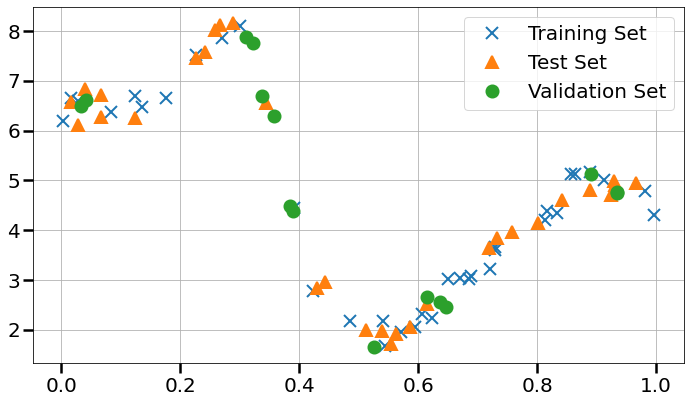

In [6]:
TV_ratio = 0.3 #Define splitting ratio btw. training and validation set, in [0,1]

N_sample = np.size(x_train)
Val_size = np.ceil(N_sample*TV_ratio)

rng = np.random.default_rng(7) #seed value set for repeatable results!!
pos = rng.choice(N_sample,Val_size.astype(int), replace=False) #Draw non-repetitive random numbers

x_validation = x_train[pos]
y_validation = y_train[pos]

x_train2 = np.delete(x_train, pos)
y_train2 = np.delete(y_train, pos)

# Plot the splitted data-set
plt.figure(figsize=(10,6))
plt.plot(x_train2, y_train2, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.plot(x_validation, y_validation, 'o', label='Validation Set')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Evaluation based on validation set performance:

In [ ]:
P_max = 25

residuals_validation = np.zeros(P_max-1)
residuals_train = np.zeros(P_max-1)
residuals_test = np.zeros(P_max-1)

for order in range(1,P_max):
    
    p = np.polyfit(x_train2, y_train2, order, full=False)
    residuals_train[order-1] = MSE(p,x_train2, y_train2)
    residuals_validation[order-1] = MSE(p,x_validation, y_validation)
    residuals_test[order-1] = MSE(p,x_test, y_test)
    
validation_min = np.where(residuals_validation == np.amin(residuals_validation)) #optimal order
test_min = np.where(residuals_test == np.amin(residuals_test))

print('Optimal polynomial order for validation set: ', validation_min[0]+1, 'with MSE: ', residuals_validation[validation_min[0]])
print('Optimal polynomial order for test set: ', test_min[0]+1, 'with MSE: ', residuals_test[test_min[0]])

Visual inspection of the results:

In [ ]:
#Plot the training and validation MSE curve

plt.close('all')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,P_max),residuals_train, label='Training set')
plt.plot(np.arange(1,P_max), residuals_validation, label='Validation set')
plt.xlabel('Polynomial order P')
plt.ylabel('MSE')
plt.title('Comparision training and validation MSE')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

disp('Figure 3. MSE of the training-, and validation-set over polynomial order')

#Plot of the optimal model based on test set

x_eval = np.arange(0,1,0.01)
y_opt_model = PolyModelEval(validation_min[0]+1, x_train2, y_train2, x_eval)

plt.figure(figsize=(10,6))
plt.plot(x_train2, y_train2, 'x', label='Training set')
plt.plot(x_test, y_test, 'o', label='Test set')
plt.plot(x_eval, y_opt_model, label='Optimal validation model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Optimal validation model')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

disp('Figure 4. Optimal validation model')


Figure 3. shows again the MSE of the different models, over the training-, and validation sets for increasing polynomial order $P$. The behaviour of the MSE for low polynomial order is quite similar to the previous case with the test set. Nevertheless, the MSE difference in this region is much larger. After $P\sim 11 $, both curves converge approximately to the same value, with a minimum MSE on the validation set at $P=21$. Further increasing $P$ causes a rapid increase of the MSE on the validation set, while the training MSE is still decreasing. This clearly indicates overfitting to the training set. 

As mentioned, the best model for the validation set has order $P=21$, and archives a MSE of $0.052$ on the test set. This is a quite similar result as in the first task, although the overall MSE is slightly higher. Figure 4. shows this optimal validation model along with the given data for the (reduced) training set, and the test set. 

This split size has a direct effect on the model quality, as we are working with a relatively small data set.  Therefore, increasing the ```TV_ratio``` reduces the training set, which is necessary for basic model construction. On the other hand, the quality of the validation set improves, as more and more samples are available for model evaluation. In contrast to that, a small ```TV_ratio``` might not represent the actual function in the validation set, as only very few samples are available for the model evaluation. As a consequence, unfavorable models might yield a small validation MSE. 

In our case, we came up with the optimal splitting ratio by varying its value, and analyzing the MSE on the training, and validation set. The lowest MSE was archived for a ```TV_ratio``` of $0.3$, and yielded in $MSE_{valid} = 0.039$, and $MSE_{test} = 0.0524$ 

<hr style='border:2.2px solid Black'></hr>

**Task c)** Use a Gaussian radial basis function ($RBF$) model $\hat{f} of order $P$$

$\hat{f}(x) = \alpha_0 + \sum_{p=1}^{P} \alpha_p e^{\frac{-(x-c_p)^2}{2\omega_p^2}}$

To avoid a nonlinearity, the centers of the P-$RBF$ are chosen evenly spaced over the support of the given data. Using the given data sets $\mathbf{x}[n]$, and $\mathbf{y}[n]$, a simplification to a linear model in the coefficients $\alpha_p$ is possible. This can be further rewritten to a linear matrix vector multiplication:

\begin{equation}
    \mathbf{y}_{train} = \mathbf{A} \cdot \alpha
\end{equation}

Where $A$ is defined as:
&ensp;

\begin{equation}
A = \begin{bmatrix}
1 & e^{\frac{-(x[0]-c_1)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_1)^2}{2\omega^2}} & \dots & e^{\frac{-(x[N]-c_1)^2}{2\omega^2}}\\
1 & e^{\frac{-(x[0]-c_2)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_2)^2}{2\omega^2}} & \dots & e^{\frac{-(x[N]-c_2)^2}{2\omega^2}}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & e^{\frac{-(x[0]-c_P)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_P)^2}{2\omega^2}} & \dots &  e^{\frac{-(x[N]-c_P)^2}{2\omega^2}}
\end{bmatrix}
\end{equation}

And $\alpha$ denotes the coefficient vector, consisting of all $\alpha_i$.

The optimal coefficient vector $\alpha_{opt}$ is determined by means of minimizing the MSE for the given model order P:

\begin{equation}
\alpha_{opt} = \underbrace{(\mathbf{A}^T\mathbf{A})^{-1} \mathbf{A}^T}_{\text{Moore–Penrose inverse}}\cdot  \mathbf{y}_{train}
\end{equation}

We implemented the computation of matrix A in the function ```RbfOptimizer(P, w, x)```, and computed the optimal coefficient vector using ```np.linalg.pinv(A).dot(y_train)```. The benefit of this method is that once A was computed, the model could be easily evaluated by a multiplication with the coefficient vector $\alpha$.


**Model design**

Three parameters must be manually chosen before the RBF-model could be evaluated. The first one, $P$, determines the number of Gaussian basis functions, used to approximate the nonlinear system. It is a very crucial parameter, as it directly affects the performance of the model. Choosing $P$ too low will yield in a very smooth model (if $\omega^2$ is large), which is not capable of modeling any rapid changes in the evaluated system. This is a direct effect of the inherent smoothness of gaussian RBF. On the other hand, a large $P$, compared with a small width parameter $\omega^2$ will create a delta like model, which is very susceptible to overfitting. (Can be easily created by changing $P$ to $200$) Hence, we choose $P=20$, as it seems like a reasonable number for representing the given system. 

Once $P$ is fixed, the individual positions of the basis functions $c_p$ must be defined. This was straightforward in our case, as the RBF should be evenly spaced over the support. Therefore, their position was computed using ```rbf_center = np.arange(0,1,1/P)```. 

The last parameter to choose was the width parameter $\omega^2$. It defines the width of the gaussian basis functions, and was chosen equally for all functions ($\omega^2 = \omega_p^2$) to simplify the computation of the model. As previously mentioned, a smaller $\omega^2$ results in narrower basis functions, which can be used to model e.g., a rapidly changing function. Nevertheless, problems with overfitting might occur. If $\omega^2$ is too large, the individual basis functions start to overlap significantly, and cannot resolve rapid changes, or smaller structures in the original system. We have chosen a dynamic width parameter for our system, depending on the number of basis functions with $\omega^2 = \big(\frac{2}{\alpha}\big)^2$. Therefore, a sufficient overlap between the RBG could be guaranteed, while maintaining the necessary model resolution. 

Problems could occur if the width parameter $\omega^2$ is independent of the model order $P$, as a smaller order requires wider basis functions to cover the full domain of $x$. If this connection is omitted, the model would be unable to model the system. In this case, the narrow RBF's would drop so fast towards zero, that the region between adjacent RBF's could not modeled with the available functions. The problem is less important in the other case - many RBF's with large width parameter, as some RBF's could be simply suppressed by setting their corresponding $\alpha$ to zero.

**Model evaluation**
The optimal model order was determined by evaluating the model with the reduced test set, and computing the MSE on the validation set. The optimal model on the validation set was then evaluated on the test set. The location parameter $c_p$, and the width parameter $\omega^2$ where chosen as previously described.


In [ ]:
#Determine the optimal order based on validation set performance
P = 26 # max number of RBF's

mse_train = np.zeros([P-1,1])
mse_valid = np.zeros([P-1,1])

for order in range(1,P):
    w2 = (2/order)**2                    #width parameter squared
    rbf_center = np.arange(0,1,1/order)  #RBF centers
    
    A = RbfOptimizer(order, w2, x_train2)     
    c_opt = np.linalg.pinv(A).dot(y_train2)
    
    y_hat_train = RbfOptimizer(order, w2, x_train2).dot(c_opt)
    y_hat_valid = RbfOptimizer(order, w2, x_validation).dot(c_opt)
    mse_train[order-1] = np.mean((y_hat_train-y_train2)**2)  
    mse_valid[order-1] = np.mean((y_hat_valid-y_validation)**2)
    
mse_min_train = np.where(mse_train == np.amin(mse_train)) #optimal order

print('Optimal RBF order for training set: ', mse_min_train[0]+1, 'with MSE: ', mse_train[mse_min_train[0]])

mse_min_valid = np.where(mse_valid == np.amin(mse_valid)) #optimal order
print('Optimal RBF order for validation set: ', mse_min_valid[0]+1, 'with MSE: ', mse_valid[mse_min_valid[0]])

plt.figure(figsize=(10,6))
plt.plot(np.arange(1,P,1), mse_train, label='Training set')
plt.plot(np.arange(1,P,1), mse_valid, label='Validation set')
plt.xlabel('RBF order')
plt.title('Comparision training and validation MSE')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

disp('Figure 5. MSE of the training-, and validation-set over RBF order')


Figure 5. shows again the MSE over the RBF order. The lowest MSE on the validation set was archived for $P=13$. Therefore, a RBF model of this order was then evaluated on the test set:

In [ ]:
P = 13 #number of RBF's

rbf_center = np.arange(0,1,1/P)
w2 = (2/P)**2 #width parameter sqared

A = RbfOptimizer(P, w2, x_train2)     
c_opt = np.linalg.pinv(A).dot(y_train2)

#Evaluate the model with test set

y_hat = RbfOptimizer(P, w2, x_test).dot(c_opt)  #for MSE compuation
mse = np.mean((y_hat-y_test)**2)  

print('MSE on test set: ', mse)

x_eval = np.arange(0,1,0.01)
y_eval_stat = RbfOptimizer(P, w2, x_eval).dot(c_opt) #for plot

#Plot the model for the selected model order P

plt.figure(figsize=(10,6))
plt.plot(x_train2, y_train2, 'x', label = 'Training Set')
plt.plot(x_test, y_test, 'o', label='Test Set')
plt.plot(x_eval, y_eval_stat, label = 'Optimal RBF Static Model')
plt.plot(x_eval, y_opt_model, label='Optimal Polynomial Model')
plt.title('Optimal RBF model')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

disp('Figure 6. Model comparision of the optimal RBF, and polynomial model')

The RBF model of order $P=13$ archived an MSE of $0.0508$ on the test set. This is slightly lower than the $0.0524$, archived with the polynomial model of order $P=21$.

Figure 6. shows now a direct comparison of the optimal (w.r.t the MSE on the validation set) RBF-, and polynomial models. Both models fit very well to the data, and behave nearly identical in the region between $0.2$ and $0.9$. Nevertheless, the polynomial model shows beginning overfitting in the outer regions. Hence, the RBF model should be preferred over the polynomial model for predicting samples outside the given test, and training sets.

Manually selecting the widths-, and centers will be problematic for high-dimensional input data. In this case, the evenly spaced RBF, and potential different $\omega^2$ would create a model with a huge number of parameters ($\alpha_p$) which must be optimized. Not only will this be a very difficult task, but the high complexity is also surely not necessary. The data will most likely populate some subspace of the high dimensional input space, such that a modeling capability in the whole $\mathrm{R}^{100}$ is surely not needed. Therefore, learning the width-, and position parameters is an inportant task.

<hr style='border:2.2px solid Black'></hr>

**Task d)** Learn the optimal centers and widths using gradient descent (GD) applied on a RBF-NN. 

Implementing the RBF-model in a neuronal-network (NN) is not a straightforward process. Therefore, is always a good idea to start small, determine the dimensionality of the variables, and explicitly formulate the nonlinear transform depicted in the NN. Starting with $P=3$, a RBF-NN for $x\in \mathrm{R}^1, y\in \mathrm{R}^1$ and $\hat{f}(x): \mathrm{R}^1 \rightarrow \mathrm{R}^1$ would look like:

\begin{equation}
 y = \hat{f}(x) = \alpha_0 + \sum_{p=1}^3 \alpha_p ~\big[\phi ( \omega_{p,1}\cdot x_1+ \omega_{p,0})\big]
\end{equation}

This could be expressed for the given Gaussian basis functions (RBF):

\begin{equation}
 y = \hat{f}(x) = \alpha_0 + \sum_{p=1}^3 \alpha_p~ \exp{\big[ \frac{-1}{2\omega_p^2} (x-c_p)^2\big]}
\end{equation}

Which is equivalent to:

\begin{equation}
 y = \hat{f}(x) = \alpha_0 + \sum_{p=1}^P \alpha_p \exp{ \bigg(-\Big[ \sqrt{\frac{1}{2\omega_p}} \cdot x - c_p \sqrt{\frac{1}{2\omega_p^2}} \Big]^2 \bigg)}
\end{equation}

In this case, the nonlinear activation function $\phi(x) = \exp{-[x]^2}$, as well as the linear transform $z(x) = \underbrace{\sqrt{\frac{1}{2\omega_p}}}_{\omega_{p,1}} \cdot x + \underbrace{(-c_p \sqrt{\frac{1}{2\omega_p^2}})}_{\omega_{p,0}} \text{so} \quad z_p = \omega_{p,1} \cdot x + \omega_{p,2}$ becomes visible. Following from that, a simple sketch of the NN can be drawn:


![System identification setup](../../data/figures/RBF_NN.jpg)
&ensp;
&ensp;
&ensp;
<center> <em>Figure 7. Sketch of a simple NN with order P=3</em> </center>

As we deal with a one dimensional input parameter, the weight matrix
simplifies to a weight vector:
\begin{equation}
    \omega_{p_1} = \left[\sqrt{\frac{1}{2\omega_1}}, \sqrt{\frac{1}{2\omega_2}}, \sqrt{\frac{1}{2\omega_3}} \right]^T, \quad \text{and} \quad \omega_{p_0} = \left[-c_1 \sqrt{\frac{1}{2\omega_1^2}}, -c_2 \sqrt{\frac{1}{2\omega_2^2}}, -c_3 \sqrt{\frac{1}{2\omega_3^2}} \right]^T
\end{equation}

**Compute the gradients**

The gradient $\nabla$ could be computed with respect to the weights ($\nabla{\alpha}$), the width parameters ($\nabla{\omega}$) or the centers ($\nabla{c}$). Each gradient is hereby defined as:

\begin{equation}
\nabla_{x} = \left( \begin{array}{c} \frac{\partial}{\partial x_1}\\ \frac{\partial}{\partial x_2} \\ \frac{\partial}{\partial x_3} \end{array}\right)
\end{equation}

Therefore:

\begin{equation}
\nabla_{\omega} \hat{f}(x) = \left( \begin{array}{c} \alpha_1 \frac{1}{\omega_1^3}(x-c_1)^2\exp{\big(\frac{-1}{2\omega_1^2}(x-c_1)^2\big)}\\ \alpha_2 \frac{1}{\omega_2^3}(x-c_2)^2\exp{\big(\frac{-1}{2\omega_2^2}(x-c_2)^2\big)}\\ \alpha_3 \frac{1}{\omega_3^3}(x-c_3)^2\exp{\big(\frac{-1}{2\omega_3^2}(x-c_3)^2\big)} \end{array}\right)
\end{equation}

and:

\begin{equation}
\nabla_{c} \hat{f}(x) = \left( \begin{array}{c} \alpha_1 \frac{1}{\omega_1^2}(x-c_1)\exp{\big(\frac{-1}{2\omega_1^2}(x-c_1)^2\big)}\\ \alpha_2 \frac{1}{\omega_2^2}(x-c_2)\exp{\big(\frac{-1}{2\omega_2^2}(x-c_2)^2\big)}\\ \alpha_3 \frac{1}{\omega_3^2}(x-c_3)\exp{\big(\frac{-1}{2\omega_3^2}(x-c_3)^2\big)} \end{array}\right)
\end{equation}

as well as:


\begin{equation}
\nabla_{\alpha} \hat{f}(x) = \left( \begin{array}{c} 1\\ \exp{\big(\frac{-1}{2\omega_1^2}(x-c_1)^2\big)}\\ \exp{\big(\frac{-1}{2\omega_2^2}(x-c_2)^2\big)}\\ \exp{\big(\frac{-1}{2\omega_3^2}(x-c_3)^2\big)} \end{array}\right)
\end{equation}


**Model implementation**

For this task, the given MLP was adapted to utilize RBFs as activation functions. This was easily implemented in the forward-pass by computing the output of the input layer with a Gaussian function```z1 = torch.exp(-torch.pow(self.hidden_layer_1(x),2))```. The model order was chosen empirically, and defined as 20. It was trained using the reduced training set to guarantee comparable results for all tasks. Afterwards, the model was evaluated on the test set to determine the archived MSE.


In [ ]:
from src.models.rbf_mlp import RbfMLP

rbf_mlp_model = RbfMLP(hidden_size = 20) #change model order with hidden size
loss_list = rbf_mlp_model.fit(x_train2, y_train2, learning_rate=1e-2, max_epochs=1000)

plt.figure(figsize=(10,6))
plt.plot(list(range(1, 1 + len(loss_list))), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Set MSE')
plt.grid()
plt.tight_layout()
plt.show()

disp('Figure 7. Evolution of the training MSE over the epochs.')

In [ ]:
x_eval = np.arange(0,1,0.01)

approx_output = rbf_mlp_model.predict(x_eval)
y_pred = rbf_mlp_model.predict(x_test)

print(f'Training MSE is {loss_list[-1]:.4f}')
print(f'Test MSE is {np.mean((y_test-np.transpose(y_pred))**2):.4f}')


#plt.figure(figsize=(10,6))
#plt.plot(x_train2, y_train2, 'o', label='Training Samples')
#plt.plot(x_test, y_test, 'x', label='Test Samples')
#plt.plot(x_eval, approx_output, label='RBF-NN Model')
#plt.plot(x_eval, y_eval_stat, label = 'Static RBF Model')
#plt.xlabel('Input, $x$')
#plt.ylabel('Output, $y$')
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.show()

#disp('Figure 8. Model comparision.')


![System identification setup](../../data/figures/p1_d_low_training_test_mse.png)
&ensp;
&ensp;
&ensp;
<center> <em> Figure 8. Comparision of the different RBF models</em></center>
&ensp;
&ensp;
&ensp;


Figure 8. shows a comparison of the best RBF-NN model, and the best static RBF-model. The plotted RBF-NN model was found using a single layer NN with 20 neurons, $1000$ epochs of training and a learning rate of $\eta = 0.01$. The biggest difference is visible in the region of $x\in [0.7 ~ 1]$, where the RBF-NN model shows a smoother behaviour than the static-RBF model. This seems like a more realistic behaviour of the nonlinearity, and suggests together with significantly lower training MSE of $MSE_{train} = 0.326$, that the RBF-NN model performs better. Interestingly, the MSE is even lower on the test-, than on the training set, which suggests very good generalization.

Nevertheless, the result was not surprising, as variable position-, and width parameters clearly extend the modeling capabilities of the RBF-model. The problems of too small/large overlap between basis-functions as described in Task c), can be avoided with this method. 

**Finding the centers and width parameters**

RBF are very common activation functions in neuronal networks. Generally, such NN are trained in a two-stage process.
The first stage fixes the number ($P$) of RBF, and determines their centerers, as well as their width parameters. Afterwards, in the second step, the weighting coefficients $\alpha_i$ are learned to fit the network to the training data. 

One approach for determining $P$, and $\mathbf{c}$ is to fit a RBF to each data sample. This guarantees an exact fit of the model to the training data. Nevertheless, such an approach is only useful for noise free data. Hence, other methods where developed, which are e.g. based on randomly locating the centers, or a prior clustering of the training data with algorithms as K-means. The benefit of prior clustering is that the RBF could be placed in the center of the cluster, and represent therefore the density of the training data. \citet{Yousef2005} states additional methods which are based on genetic algorithms, decision trees, or supervised learning.

After these two parameters are fixed, the with parameter must be chosen, or learned. A common procedure is to choose $\omega^2$ heuristically, and fixing its value for all RBF-kernels. A more formal way is to define $\omega_p^2$ by using the Euclidian distance to the adjacent RBF. A problem with this method is the increased computational effort, especially for higher dimensional data sets. One way to overcome this problem is again to fix the width for all RBF, and define the common with parameter over the maximum distance (d) between two chosen centerers for all k RBF's: \cite{Yousef2005}

\begin{equation}
\omega^2 = d/\sqrt{2 k}
\end{equation}

<hr style='border:2.2px solid Black'></hr>

**Task e)** Approximation using a feed-forward neuronal network. 

For this task, the previous RBF-NN was extended such that the layer size, as well as the number of neurons per layer could be chosen manually. The network is defined using the parameter ```h_list``` whose size define the number of layers in the network, and whose elements define the number of neurons per layer. ```h_list = [20,20,20]``` would for example create a 3-layer NN, with 20 neurons per layer. The activation function of the network is fixed, and could be changed if necessary in the ```forward``` function of the ```variable_rbf_mlp.py```. Note that this model assumes at least two layers!

**Training**

As in the previous cases, the model was again trained with the reduced data set for a better comparability with the other models. Overall, four different activation functions where tried: the gaussian RBF, tanh, relu, and the sigmoidal activation function. Each function was tested for selected combinations of 2-5 layers with 20-200 neurons per layer. The model was trained with a learning rate $\eta = 0.005$ for $1000$ epochs. 


&ensp;


In [ ]:
from src.models.variable_rbf_mlp import VarRbfMLP

h_list = [20, 20] # [20, 20, 20] creates a 3 layer NN with 20 neurons per layer 

#sigmoidal activation function selected

rbf_mlp_model = VarRbfMLP(h_sizes = h_list)
loss_list = rbf_mlp_model.fit(x_train2, y_train2, batch_size=15
                              , learning_rate=9e-3, max_epochs=10000)

x_eval = np.arange(0,1,0.01)

approx_output_mlnn = rbf_mlp_model.predict(x_eval)
y_pred = rbf_mlp_model.predict(x_test)


In [ ]:
print('')
print(f'Training MSE is {loss_list[-1]:.4f}')
print(f'Test MSE is {np.mean((y_test-np.transpose(y_pred))**2):.4f}')

plt.figure(figsize=(16,10))
plt.plot(x_train2, y_train2, 'o', label='Training Samples')
plt.plot(x_test, y_test, 'x', label='Test Samples')
plt.plot(x_eval, approx_output_mlnn, label='ML-NN Model')
plt.plot(x_eval, approx_output, label = 'RBF-NN Model')  
plt.plot(x_eval, y_opt_model, label = 'Poynomial Model')
plt.plot(x_eval, y_eval_stat, label = 'Static RBF Model')
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

disp('Figure 9. Model comparision.')

The final model of the multilayer NN used a sigmoidal activation function in a 2-layer network with 20 neurons per layer. The networks were trained for $10000$ epochs with $\eta=0.009$, and reached a $MSE_{test}$ of $0.0289$. This is a smaller MSE than for the single-layer RBF-model! 

Figure 9. shows a comparison of this model with the optimal single-layer RBF model. The increased performance on the training set can be explained when the region around $x=0.95$ is considered, as the RBF-NN model is decreasing to adapt to the training samples, while the ML-RBF-NN model increases, and fits better to the test samples. As the model performance should not be solely determined by the MSE, the RBF-NN model should be still considered as the better model.

<hr style='border:2.2px solid Black'></hr>

**Task f)** Conclude your findings of the experiments

Sigmoidal activation function: 

The sigmoidal activation function delivered the best results beside the Gaussian RBF. A combination of a 3-layer network with 200 neurons per layer resulted in a training error $MSE_{train}$ of $0.023$, and a test error $MSE_{test}$ of $0.054$. Increasing the number of layers, as well as the number of training epochs decreased the MSE on the training set further (down to $0.198$), but increased again the MSE on the test set as the model began with overfitting. Changing the model structure to a two layer network with 20 neurons increased the performance on the test set drastically, and delivered a $MSE_{test}$ of $0.0289$, which is even better than the RBF model (but see the comments in Task e) ). 

The tanh activation function performed similar (concerning the MSE) to the sigmoidal one, but delivered models which were not as smooth, which could be also interpreted as beginning overfitting. In addition to that, the $MSE$ on the test set was with $0.930$ the largest for all used activation functions.. 

The rectifier-linear activation function performed relatively good on the training set, delivering a $MSE_{train}$ of $0.031$. It outperformed also the tanh activation function on the test set, with a $MSE_{test}$ of $0.056$. The nature of the activation function was also visible in the estimated model, as is consisted of linear segments which where smoothly connected. 

A multi-layer NN with Gaussian RBF performed approximately as good as the single layer RBF-NN. The $MSE_{test} = 0.037$ was nevertheless still larger as for the single layer NN. Increasing either the number of neurons, or the number of layers decreased the model performance as overfitting became visible. 

Overall, this problem dealt with four different approaches to model a nonlinear system, which was observed trough noisy measurements. The complexity of the individual approaches increased, and started with a simple polynomial fit. The benefit of this method is its simplicity, compared with the acceptable results. Nevertheless, polynomial models tend to overfitting, and are unbound outside the domain of the data. 

The next approach used equally spaced Gaussian basis functions with predefined width-parameters. This approach has also a very low computational complexity, as the scaling coefficients for the RBF's can be found by a matrix inversion. The performance of the static-RBF model was slightly better than the polynomial model. Additionally, a RBF model decays towards zero outside the domain due to the nature of the Gaussian RBF's.

The width-, and position parameters of the RBF model could be learn in a NN. With this, a much better model performance could be reached, as the individual RBFs are adapted to the behaviour of the data. This model performed best in therms of generalization for the the given data set. The biggest drawback is the higher computational cost for optimizing-, and training the NN. 

The last method used a multi-layer NN. This is the most powerfull approach, which delivered also the lowest MSE of all models on the test set ($MSE_{min} = 0.0289$). Albeit the lowest MSE, the resulting model looked not as good as the ML-RBF model, as it deviated from the possible trajectory of the original system. Multi-layer NN show an even higher computational complexity, and might not be the best choice for such a simple problem as in this task. This could be also seen by the fact that the best model was still relatively small (2 layer, 20 neuron), and nearly all larger models showed some kind of overfitting.   
